In [33]:
import tensorly as tl
import numpy as np

In [34]:
!nvidia-smi

Thu Oct 29 14:54:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   29C    P8    14W / 260W |  10591MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 27%   29C    P8    10W / 260W |   1040MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

# Folding-unfolding

In [35]:
tl.set_backend('numpy')
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))
type(X)

numpy.ndarray

In [36]:
tl.unfold(X, mode=0)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23]])

In [37]:
tl.unfold(X, mode=1)

array([[ 0,  1,  8,  9, 16, 17],
       [ 2,  3, 10, 11, 18, 19],
       [ 4,  5, 12, 13, 20, 21],
       [ 6,  7, 14, 15, 22, 23]])

In [38]:
tl.unfold(X, mode=2)

array([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22],
       [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]])

# Compression

In [39]:
from tensorly.decomposition import parafac
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))

In [40]:
from tensorly.decomposition import tucker, partial_tucker

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 

from skimage.transform import resize
from skimage.data import astronaut, chelsea
from matplotlib.pyplot import imread
image1 = imread("rgb.jpeg")
image2 = np.array(astronaut(), dtype=np.float64)

# Convert it to a tensor of floats
image1 = np.array(image1, dtype=np.float64)
image2 = np.array(image2, dtype=np.float64)


def to_image(tensor):
    """convert a tensor of float values into an image
    """
    tensor -= tensor.min()
    tensor /= tensor.max()
    tensor *= 255
    return tensor.astype(np.uint8)

def show_im(img, title):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(to_image(img))
    ax.set_axis_off()
    plt.title(title)

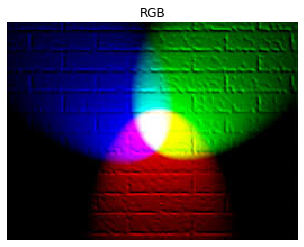

In [42]:
show_im(image1, "RGB")

**Rank along the RGB dimention is 3**

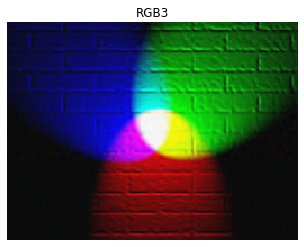

In [43]:
core, factors = tucker(image1, rank=[50, 50, 3])
rec_image = tl.tucker_to_tensor((core, factors))
show_im(rec_image, "RGB3")

**Rank along the RGB dimention is 2 - one color missing**

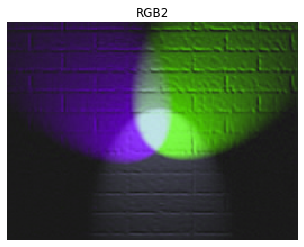

In [44]:
core, factors = tucker(image1, rank=[50, 50, 2])
rec_image2 = tl.tucker_to_tensor((core, factors))
show_im(rec_image2, "RGB2")

**Rank along the RGB dimention is 2 - all color missing**

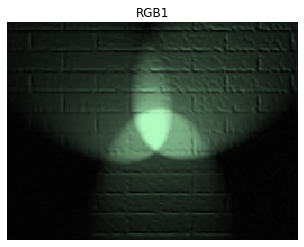

In [45]:
core, factors = tucker(image1, rank=[50, 50, 1])
rec_image1 = tl.tucker_to_tensor((core, factors))
show_im(rec_image1, "RGB1")

# Compare CPD and tucker

In [46]:
tulip = imread("tulip.png")
tulip = np.array(tulip, dtype=np.float64)

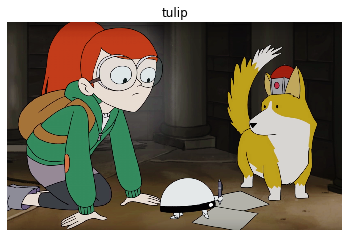

In [47]:
show_im(tulip, "tulip")

In [48]:
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil


In [49]:
image = tl.tensor(zoom(tulip, (0.3, 0.3, 1)), dtype='float64')

def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

cp_rank = 35

weights, factors = parafac(image, rank=cp_rank, init='random', tol=10e-6)
cp_reconstruction = tl.kruskal_to_tensor((weights, factors))


In [50]:
core, tucker_factors = tucker(image, ranks= [100, 100, 2], init='random', tol=10e-5)
tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))


In [51]:
from tensorly.decomposition import matrix_product_state

def tt_to_tensor(factors):
    full_shape = [f.shape[1] for f in factors]
    full_tensor = tl.reshape(factors[0], (full_shape[0], -1))

    for factor in factors[1:]:
        rank_prev, _, rank_next = factor.shape
        factor = tl.reshape(factor, (rank_prev, -1))
        full_tensor = tl.dot(full_tensor, factor)
        full_tensor = tl.reshape(full_tensor, (-1, rank_next))

    return tl.reshape(full_tensor, full_shape)

factors = matrix_product_state(image, rank=[1,100,100,1])
tt_reconstruction = tt_to_tensor(factors)
print(len(factors))
[f.shape for f in factors]

3


[(1, 186, 100), (100, 300, 3), (3, 3, 1)]

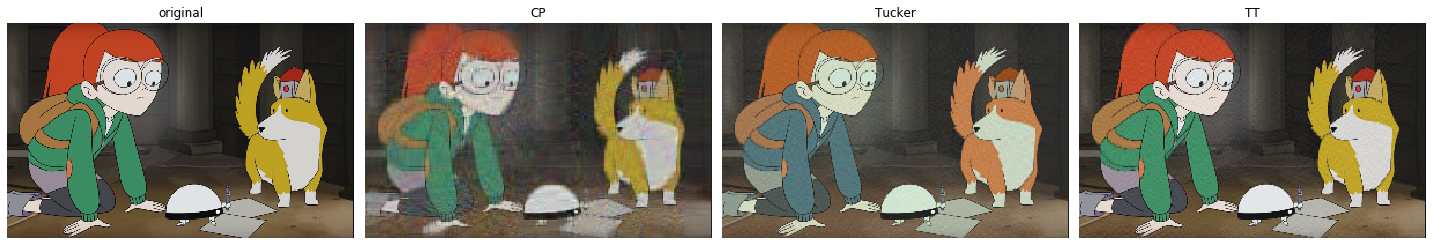

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')

ax = fig.add_subplot(1, 4, 2)
ax.set_axis_off()
ax.imshow(to_image(cp_reconstruction))
ax.set_title('CP')

ax = fig.add_subplot(1, 4, 3)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))
ax.set_title('Tucker')

ax = fig.add_subplot(1, 4, 4)
ax.set_axis_off()
ax.imshow(to_image(tt_reconstruction))
ax.set_title('TT')

plt.tight_layout()
plt.show()